In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet

### Load Data

In [2]:
df_2009 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2009.csv')
df_2010 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2010.csv')
df_2011 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2011.csv')
df_2012 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2012.csv')
df_2013 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2013.csv')
df_2014 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2014.csv')
df_2015 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2015.csv')
df_2016 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2016.csv')
df_2017 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2017.csv')
df_2018 = pd.read_csv('./Data/KCMO/KCPD_Crime_Data_2018.csv')

/Users/jeffreyherman/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### ### Deal with column name inconsistencies (Thanks Ajay!)

In [17]:
# Common column list
cols = ['Report_No', 'Reported_Date', 'Reported Time', 'From_Date', 'From Time', 'To_Date', 
        'To_Time', 'Offense', 'IBRS', 'Description', 'Beat', 'Zip Code', 
        'Rep_Dist', 'Area', 'DVFlag', 'Invl_No', 'Involvement', 'Race', 'Sex', 'Age', 
        'Location', 'Firearm Used Flag', ]

df_2009 = df_2009.rename(columns={'Location 1':'Location', 'Firearm Used Flag  ':'Firearm Used Flag'})
df_2010 = df_2010.rename(columns={'To Time':'To_Time', 'Location 1':'Location', 'Firearm Used Flag  ':'Firearm Used Flag'})
df_2011 = df_2011.rename(columns={'To Time':'To_Time', 'Location 1':'Location', 'Firearm Used Flag  ':'Firearm Used Flag'})
df_2012 = df_2012.rename(columns={'To Time':'To_Time', 'Location 1':'Location', 'Firearm Used Flag  ':'Firearm Used Flag'})
df_2013 = df_2013.rename(columns={'To Time':'To_Time', 'Location 1':'Location', 'Firearm':'Firearm Used Flag'})
df_2014 = df_2014.rename(columns={'To Time':'To_Time', 'Location 1':'Location', 'Firearm Used Flag  ':'Firearm Used Flag'})
df_2015 = df_2015.rename(columns={'To Time':'To_Time', 'Location 1':'Location'})
df_2016 = df_2016.rename(columns={'Reported_Time':'Reported Time', 'From_Time':'From Time', 'Location 1':'Location'})
df_2017 = df_2017.rename(columns={'Reported_Time':'Reported Time', 'From_Time':'From Time'})
df_2018 = df_2018.rename(columns={'Reported_Time':'Reported Time', 'From_Time':'From Time'})

df_2013 = df_2013.rename(columns=lambda x: x.strip())
df_all = pd.concat([df_2009[cols], df_2010[cols], df_2011[cols], df_2012[cols], df_2013[cols], df_2014[cols], 
           df_2015[cols], df_2016[cols], df_2017[cols], df_2018[cols]])

In [25]:
df_all['Reported_Date'] = pd.to_datetime(df_all['Reported_Date'])

/Users/jeffreyherman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


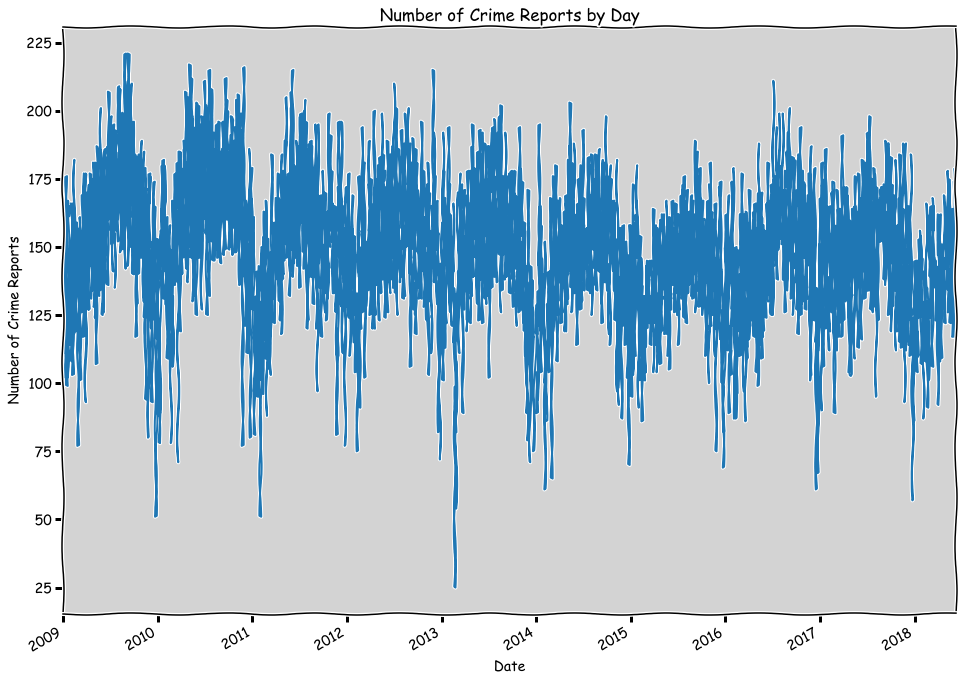

In [145]:
plt.xkcd()
daily_plt = df_all.groupby('Reported_Date')['Report_No'].nunique().plot(kind = 'line', figsize = (16, 12))
plt.xlabel('Date')
plt.ylabel('Number of Crime Reports')
plt.title('Number of Crime Reports by Day')
daily_plt.set_axis_bgcolor("#d3d3d3")
plt.show()

In [43]:
daily_crime = df_all.groupby('Reported_Date')['Report_No'].nunique()
df_prophet = pd.DataFrame(daily_crime)
df_prophet.reset_index(inplace = True)
df_prophet.columns = ['ds', 'y']

In [46]:
m = Prophet()

In [52]:
df_prophet_train = df_prophet.set_index('ds')['2009-01-01':'2017-06-10']
df_prophet_test = df_prophet.set_index('ds')['2017-06-11':]
df_prophet_train.reset_index(inplace = True)
df_prophet_test.reset_index(inplace = True)

In [92]:
# Fit on Training Data
m_tt = Prophet(daily_seasonality = True)
m_tt.fit(df_prophet_train)

In [93]:
future = m_tt.make_future_dataframe(periods=365)
forecast = m_tt.predict(future)

In [95]:
resid = forecast.tail(365)
df_prophet_test.reset_index(inplace = True, drop = True)
resid = pd.merge(resid, df_prophet_test, on = 'ds', how = 'left')

In [96]:
resid['Residual'] = resid['y'] - resid['yhat']
resid['Error^2'] = resid['Residual'] ** 2
(resid['Error^2'].mean()) ** .5

17.254846454896295

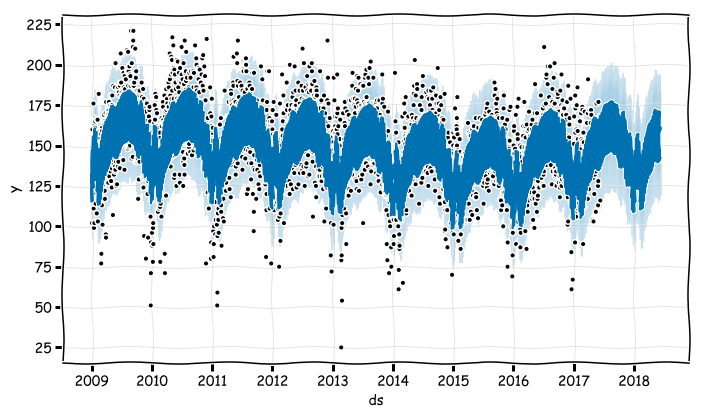

In [98]:
plt.xkcd()
fig1 = m_tt.plot(forecast)
plt.show()

In [63]:
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
    })

In [71]:
# Add Holidays

# New Years and New Years Eve
new_years = pd.DataFrame({
    'holiday': 'new_years',
    'ds': pd.to_datetime(['2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
                         '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01',
                         '2019-01-01']),
    'lower_window': -1,
    'upper_window': 0
})

# MLK Day
mlk = pd.DataFrame({
    'holiday': 'mlk',
    'ds': pd.to_datetime(['2009-01-19', '2010-01-18', '2011-01-17', '2012-01-16', '2013-01-21',
                         '2014-01-20', '2015-01-19', '2016-01-18', '2017-01-16', '2018-01-15',
                         '2019-01-21']),
    'lower_window': 0,
    'upper_window': 0
})


# Presidents Day
presidents = pd.DataFrame({
    'holiday': 'presidents',
    'ds': pd.to_datetime(['2009-02-16', '2010-02-15', '2011-02-21', '2012-02-20', '2013-02-18',
                         '2014-02-17', '2015-02-16', '2016-02-15', '2017-02-20', '2018-02-19',
                         '2019-02-18']),
    'lower_window': 0,
    'upper_window': 0
})

# Memorial Day
memorial = pd.DataFrame({
    'holiday': 'memorial',
    'ds': pd.to_datetime(['2009-05-25', '2010-05-31', '2011-05-30', '2012-05-28', '2013-05-27',
                         '2014-05-26', '2015-05-25', '2016-05-30', '2017-05-29', '2018-05-28',
                         '2019-05-27']),
    'lower_window': 0,
    'upper_window': 0
})

# Independence Day
independence = pd.DataFrame({
    'holiday': 'independence',
    'ds': pd.to_datetime(['2009-07-04', '2010-07-04', '2011-07-04', '2012-07-04', '2013-07-04',
                         '2014-07-04', '2015-07-04', '2016-07-04', '2017-07-04', '2018-07-04',
                         '2019-07-04']),
    'lower_window': 0,
    'upper_window': 0
})

# Labor Day
labor = pd.DataFrame({
    'holiday': 'labor',
    'ds': pd.to_datetime(['2009-09-07', '2010-09-06', '2011-09-05', '2012-09-03', '2013-09-02',
                         '2014-09-01', '2015-09-07', '2016-09-05', '2017-09-04', '2018-09-03',
                         '2019-09-02']),
    'lower_window': 0,
    'upper_window': 0
})

# Columbus Day
columbus = pd.DataFrame({
    'holiday': 'columbus',
    'ds': pd.to_datetime(['2009-10-12', '2010-10-11', '2011-10-10', '2012-10-08', '2013-10-14',
                         '2014-10-13', '2015-10-12', '2016-10-10', '2017-10-09', '2018-10-08',
                         '2019-10-14']),
    'lower_window': 0,
    'upper_window': 0
})

# Veterans Day
vets = pd.DataFrame({
    'holiday': 'vets',
    'ds': pd.to_datetime(['2009-11-11', '2010-11-11', '2011-11-11', '2012-11-11', '2013-11-11',
                         '2014-11-11', '2015-11-11', '2016-11-11', '2017-11-11', '2018-11-11',
                         '2019-11-11']),
    'lower_window': 0,
    'upper_window': 0
})

# Thanksgiving Day
thanks = pd.DataFrame({
    'holiday': 'thanks',
    'ds': pd.to_datetime(['2009-11-26', '2010-11-25', '2011-11-24', '2012-11-22', '2013-11-28',
                         '2014-11-27', '2015-11-26', '2016-11-24', '2017-11-23', '2018-11-22',
                         '2019-11-28']),
    'lower_window': 0,
    'upper_window': 0
})

# Christmas
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': pd.to_datetime(['2009-12-25', '2010-12-25', '2011-12-25', '2012-12-25', '2013-12-25',
                         '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25', '2018-12-25',
                         '2019-12-25']),
    'lower_window': -1,
    'upper_window': 0
})

holidays = pd.concat((new_years, mlk, presidents, memorial, independence, labor, columbus, vets, thanks, 
                     christmas))

In [122]:
# Fit on Training Data
m_tt = Prophet(holidays = holidays, daily_seasonality = True)
m_tt.fit(df_prophet_train)

In [123]:
future = m_tt.make_future_dataframe(periods=365)
forecast = m_tt.predict(future)

resid = forecast.tail(365)
df_prophet_test.reset_index(inplace = True, drop = True)
resid = pd.merge(resid, df_prophet_test, on = 'ds', how = 'left')

resid['Residual'] = resid['y'] - resid['yhat']
resid['Error^2'] = resid['Residual'] ** 2
(resid['Error^2'].mean()) ** .5

16.378617231491326

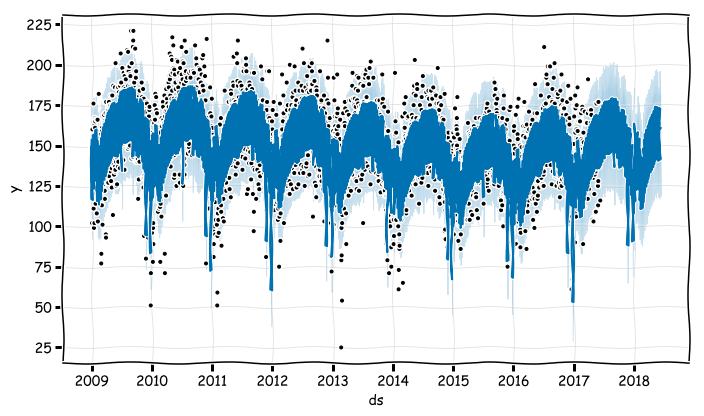

In [124]:
plt.xkcd()
m_tt.plot(forecast)
plt.show()

In [137]:
m = Prophet(holidays = holidays, daily_seasonality = False)
m.fit(df_prophet)

In [141]:
future = m.make_future_dataframe(periods=569)
forecast = m.predict(future)

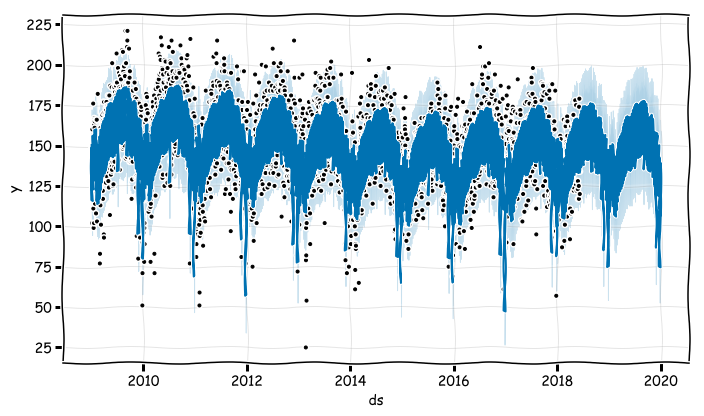

In [142]:
fig1 = m.plot(forecast)
plt.show()

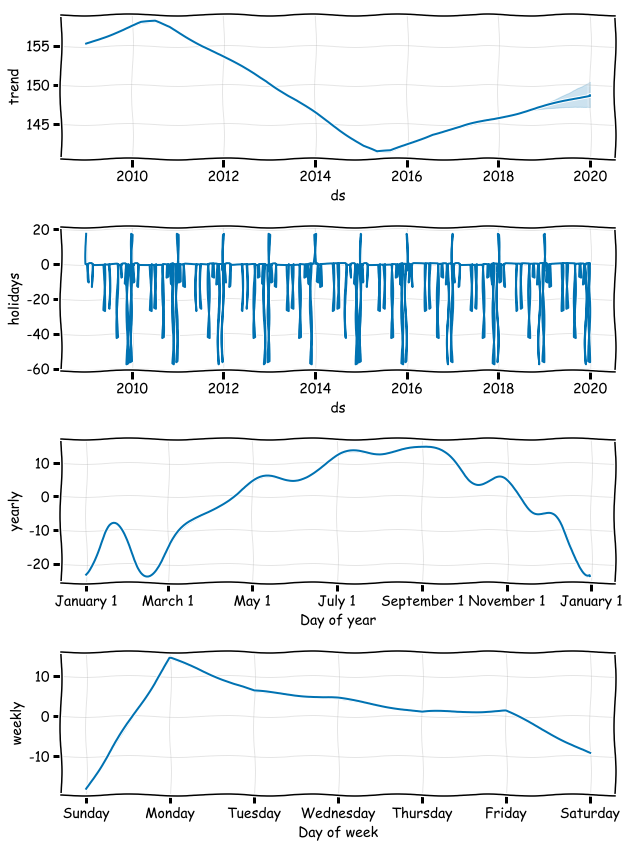

In [143]:
fig2 = m.plot_components(forecast)
plt.show()